# Target prioritisation validation based on Open Targets score for IBD

For this MVP I just parsed  IBD-target evidence from Open Targets platform interface (this step can be improved in future).

Sources of evidence: Genetic evidence, Animal models, Expression Atlas.

We should exclude evidence sources that can be built on info about known IBD drug targets to make validation more sensible.

For **globalScore** calculation only these sources are used:
- otGeneticsPortal
- geneBurden
- eva
- uniprotLiterature (?)
- uniprotVariants (?)
- impc
- expressionAtlas

*? - means we are not sure but decided to use it for the mvp*

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
evidence_ibd_path = "data/OT-EFO_0003767-associated-targets-24_04_2024-v24_03.tsv"
evidence_ibd = pd.read_csv(evidence_ibd_path, delimiter='\t')
evaluation_set = evidence_ibd[["symbol", "globalScore"]].sort_values('globalScore', ascending=False)

In [6]:
drug_targets_path = "data/known_drug_targets_from_OT.tsv"
drug_targets = pd.read_csv(drug_targets_path, delimiter='\t')
validation_set = drug_targets[["symbol"]]

In [7]:
# creating the ideal ranking
validation_set['rank_ideal'] = validation_set.reset_index().index

/var/folders/xs/llnz2_gn4fsfwjd4c0prr1w00000gp/T/ipykernel_1529/4089847658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['rank_ideal'] = validation_set.reset_index().index


In [11]:
# merging the dataframes
merge_df = evaluation_set.merge(validation_set, on='symbol', how='left')
merge_df['rank'] = merge_df['globalScore'].rank(method='min', ascending=False)

In [13]:
def precision_at_k(df, k):
    df_topk = df[df['rank'] <= k]
    precision = len(df_topk[df_topk['rank_ideal'] <= k]) / len(df_topk) if len(df_topk) > 0 else 0
    return precision

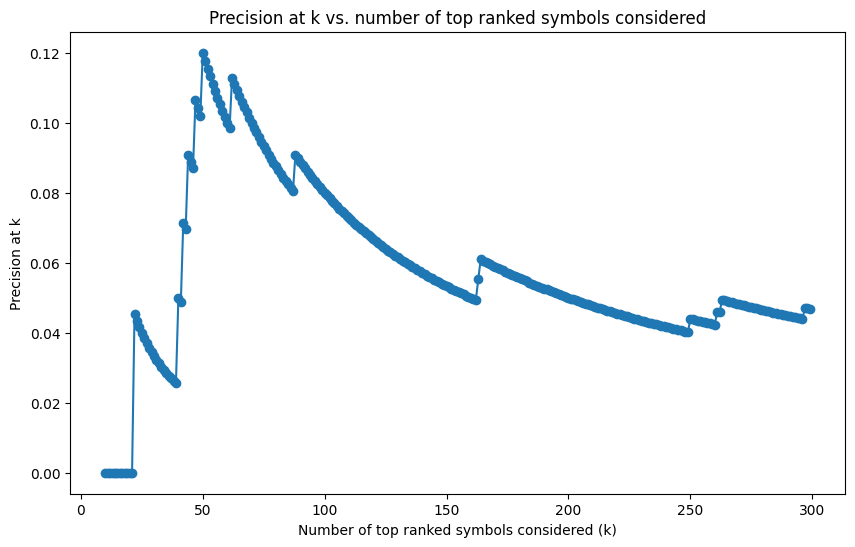

In [20]:
# set k_values as a continuous list from 10 to 1000
k_values = list(range(10, 300))

# calculate precision for each k value and store the results in a data frame
results = pd.DataFrame({
 'k': k_values,
 'precision': [precision_at_k(merge_df, k) for k in k_values]
})

# plot the results
plt.figure(figsize=(10,6))
plt.plot(results['k'], results['precision'], marker='o')
plt.title('Precision at k vs. number of top ranked symbols considered')
plt.xlabel('Number of top ranked symbols considered (k)')
plt.ylabel('Precision at k')
plt.show()